In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import SimpleITK as sitk
from monai.transforms import (
    RandFlip,
    RandRotate,
    RandAdjustContrast,
    RandSpatialCrop,
    Resize
)
import torch
from random import uniform

/u/home/seel/.conda/envs/conda-adlm/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data_path = "/data1/practical-sose23/morphometric/data_cropped/"
label_path = "/data1/practical-sose23/morphometric/picai_labels_cropped/anatomical_delineations/whole_gland/AI/Bosma22b/"

In [3]:
def get_image(patient_id):
    if not isinstance(patient_id, str):
        patient_id = str(patient_id)
    for file in os.listdir(data_path + patient_id + "/"):
        if "t2w" in file:
            image = sitk.ReadImage(data_path + patient_id + "/" +  file)
            image = sitk.GetArrayFromImage(image).astype(float)

    return image

def get_label(patient_id):
    if not isinstance(patient_id, str):
        patient_id = str(patient_id)
    for file in os.listdir(label_path + "/"):
        if patient_id in file:
            image = sitk.ReadImage(label_path + "/" +  file)
            image = sitk.GetArrayFromImage(image).astype(float)

    return image

Parameter Choice:

In [4]:
mean_vec=np.empty([90,1])
max_vec=np.empty([90,1])
perc_vec=np.empty([90,1])
last_perc_vec=np.empty([90,1])
median_vec=np.empty([90,1])
scale=np.empty([90,1])
for k in range(90):
    crop_scale=1-(k+1)*1/100
    scale[k]=crop_scale
    b=1000000
    diff=np.empty([500,1])
    for i in range(500):
        idx=b+i

        x=get_label(idx)
        ratio=((x>0.5).sum())/(x.shape[0]*x.shape[1]*x.shape[2])
        #print(ratio)

        #crop_scale=0.9
        rand_crop = RandSpatialCrop(
            roi_size=(round(x.shape[0]*crop_scale),round(x.shape[1]*crop_scale),round(x.shape[2]*crop_scale)), 
            max_roi_size=None, 
            random_center=True, 
            random_size=False,
        )
        x=torch.from_numpy(x)
        x=x[None,:]
        x=rand_crop(x)
        #x=resize(x)
        x=x.numpy()
        x=np.squeeze(x)
        #print(crop_scale)
        ratio_crop=((x>0.5).sum())*crop_scale**3/(x.shape[0]*x.shape[1]*x.shape[2])
        #print(ratio_crop)
        diff[i]=(ratio-ratio_crop)/ratio
        #print(diff[i])

    mean_vec[k]=np.mean(np.abs(diff))
    max_vec[k]=np.max(np.abs(diff))
    perc_vec[k]=np.percentile(np.abs(diff),90)
    last_perc_vec[k]=np.percentile(np.abs(diff),99)
    median_vec[k]=np.median(np.abs(diff))

FileNotFoundError: [Errno 2] No such file or directory: '/data1/practical-sose23/morphometric/picai_labels_cropped/anatomical_delineations/whole_gland/AI/Bosma22b//'

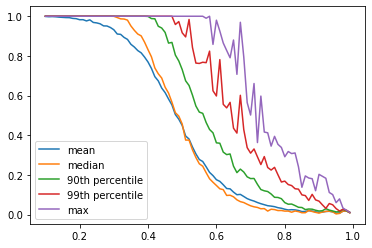

In [ ]:
from matplotlib import pyplot as plt 
plt.plot(scale,mean_vec, label="mean")
plt.plot(scale,median_vec, label="median")
plt.plot(scale,perc_vec, label = "90th percentile")
plt.plot(scale,last_perc_vec, label = "99th percentile")
plt.plot(scale,max_vec,label="max")
plt.legend(loc="lower left")

Visualizations:

In [5]:
from random import uniform
scan = get_image(10005)
torch.from_numpy(scan)
dim=(scan.shape[0],scan.shape[1],scan.shape[2])

rand_flip = RandFlip(prob=1,spatial_axis=2)

rand_rotate = RandRotate(prob=1, range_x=[-np.pi/4,np.pi/4])

rand_contrast = RandAdjustContrast(prob=0.5, gamma = [0.8,1.3])
min_crop_scale=0.2
crop_scale=0.99#uniform(min_crop_scale,0.8)
rand_crop = RandSpatialCrop(
    roi_size=(round(dim[0]*crop_scale),round(dim[1]*crop_scale),round(dim[2]*crop_scale)), 
    max_roi_size=None, 
    random_center=True, 
    random_size=False,
)

resize = Resize(spatial_size=dim)

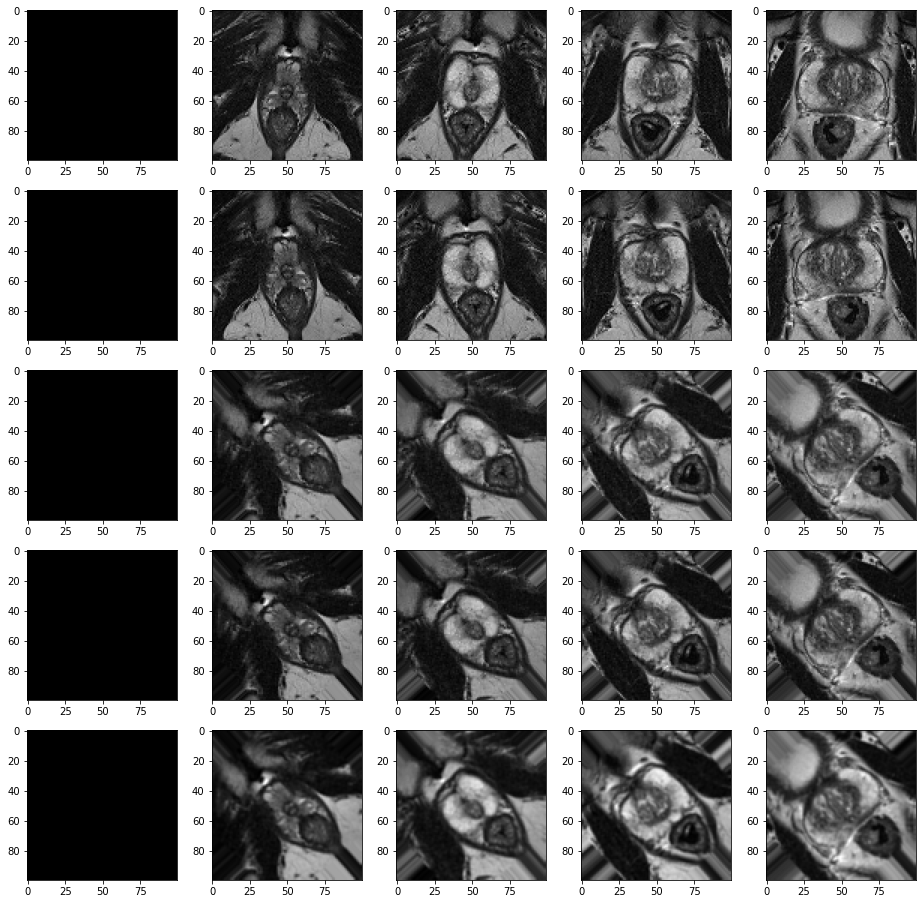

In [6]:
x = get_image(10005)
x=torch.from_numpy(x)
x=x[None,:]

plt.figure("visualise", (16, 16))
for i in range(5):
    plt.subplot(5, 5, 1+i)
    plt.imshow(x[0,5+3*i,:, :], cmap="gray")


x = rand_flip(x)
plt.figure("visualise", (16, 16))
for i in range(5):
    plt.subplot(5, 5, 6+i)
    plt.imshow(x[0,5+3*i,:, :], cmap="gray")
x = rand_rotate(x)
plt.figure("visualise", (16, 16))
for i in range(5):
    plt.subplot(5, 5, 11+i)
    plt.imshow(x[0,5+3*i,:, :], cmap="gray")
x = rand_contrast(x)
plt.figure("visualise", (16, 16))
for i in range(5):
    plt.subplot(5, 5, 16+i)
    plt.imshow(x[0,5+3*i,:, :], cmap="gray")
x = rand_crop(x)

x = resize(x)
plt.figure("visualise", (16, 16))
for i in range(5):
    plt.subplot(5, 5, 21+i)
    plt.imshow(x[0,5+3*i,:, :], cmap="gray")

Dataloader + Augmentations:

In [13]:
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2
from data_scripts.PI_CAI_Detection import PI_CAI_Detection
from torch.utils.data import DataLoader
labels_path='/data1/practical-sose23/morphometric/picai_labels_cropped'
image_path='/data1/practical-sose23/morphometric/data_cropped'
modalities=["t2w"]
targetVoxelShape= (1.0, 1.0, 3.0) #(0.5, 0.5, 3.0)#(1,1,1) #EXP1: STUPID RESULTS
targetimageSize = [200, 200, 30]#(500,500,50)
multiModel=False
useAI_Segmentation=True
biasFeildCorrection=False
toShuffle = False
batchSize = 5


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3


3


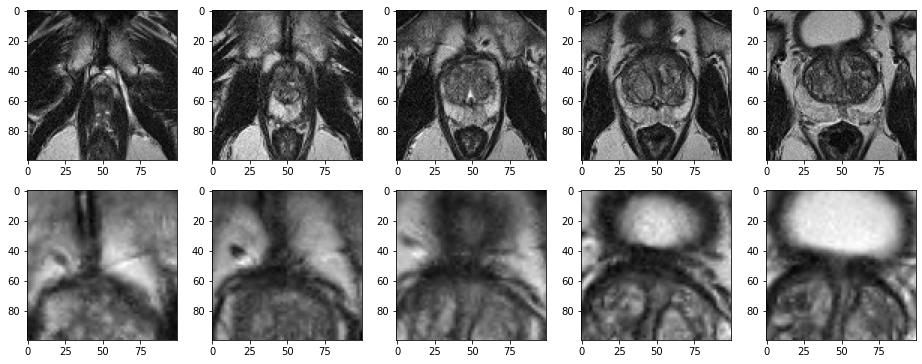

In [16]:

dataset = PI_CAI_Detection(image_path = image_path,labels_path=labels_path,modalities=modalities,\
                            multiModal=multiModel,useAI_Segmentation=useAI_Segmentation,biasFeildCorrection=biasFeildCorrection,\
                            targetVoxelShape=targetVoxelShape,targetimageSize=targetimageSize, resample=False)
loader = DataLoader(dataset,batch_size=batchSize,shuffle=toShuffle)


batch=next(iter(loader))
print(len(batch))
x=batch[0][2]
y=batch[1][2]
plt.figure("visualise", (16, 16))
for i in range(5):
    plt.subplot(5, 5, 1+i)
    plt.imshow(x[5+3*i,:, :], cmap="gray")
plt.figure("visualise", (16, 16))
for i in range(5):
    plt.subplot(5, 5, 6+i)
    plt.imshow(y[5+3*i,:, :], cmap="gray")
plt.show()